In [105]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [139]:
county_shapes = pd.read_csv("./ny_county_shapes.csv").set_index("county_name").iloc[:2]

In [140]:
len(county_shapes)

2

In [141]:
def rev_pair(l):
    return [l, l[::-1]]

def check_intersect(row):
    return (min(
        [row["scaled_min_{}_rank_{}".format(i, j[0])] <= row["scaled_max_{}_rank_{}".format(i, j[1])]
        for i in ["lng", "lat"] for j in rev_pair(["x", "y"])]))

def dist(x1, y1, x2, y2):
    return np.sqrt(np.power(x1 - x2, 2) + np.power(y1 - y2, 2))

def move(x1, y1, x2, y2, move_dist):
    d = dist(x1, x2, y1, y2)
    dist_ratio = 1.0 * (d + move_dist) / d
    new_x1 = x2 + dist_ratio * (x1 - x2)
    new_y1 = y2 + dist_ratio * (y1 - y2)
    new_x2 = x1 + dist_ratio * (x2 - x1)
    new_y2 = y1 + dist_ratio * (y2 - y1)
    return new_x1, new_y1, new_x2, new_y2

def move_row(row, move_dist):
    return move(*([row["mid_{}_rank_{}".format(i, j)] for j in ["x", "y"] for i in ["lat", "lng"]] + [move_dist]))

def untangle(county_shapes, move_dist):
    county_shapes["dummy"] = 1
    county_shapes_join = county_shapes.merge(right = county_shapes, on = "dummy", how = "left")
    county_shapes_join_diff = county_shapes_join[~(county_shapes_join.county_x == county_shapes_join.county_y)]
    
    rand_row = county_shapes_join_diff.sample().iloc[0]
    if check_intersect(rand_row):
        # print("intersects: {} and {}".format(rand_row["county_x"], rand_row["county_y"]))
        new_centers = move_row(rand_row, move_dist)
        for s, i in enumerate(["x", "y"]):
            for t, j in enumerate(["lat", "lng"]):
                old_value = county_shapes.at[rand_row["county_{}".format(i)], "mid_{}_rank".format(j)]
                new_value = new_centers[2 * s + t]
                # print("old: {} new: {}".format(old_value, new_value))
                county_shapes.at[rand_row["county_{}".format(i)], "mid_{}_rank".format(j)] = new_centers[2 * s + t]

You also have to recalculate mins and maxes!

In [142]:
for i in tqdm(range(1000)):
    untangle(county_shapes, 10)

100%|██████████| 1000/1000 [00:07<00:00, 140.82it/s]


In [143]:
orig_county_shapes = pd.read_csv("./ny_county_shapes.csv").set_index("county_name").iloc[:2]

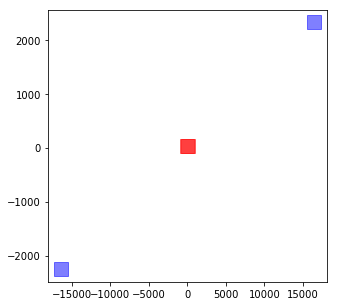

In [144]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.scatter(x = county_shapes.mid_lng_rank, y = county_shapes.mid_lat_rank, c = "blue", marker = "s", s = 200, alpha = 0.5)
ax.scatter(x = orig_county_shapes.mid_lng_rank, y = orig_county_shapes.mid_lat_rank, c = "red", marker = "s", s = 200, alpha = 0.5)

In [145]:
county_shapes

,min_lng_rank,min_lat_rank,max_lng_rank,max_lat_rank,num_squares,county,ttl,pre_mult,mult,sqrt_mult,mid_lng_rank,mid_lat_rank,lat_rank_range,scaled_min_lat_rank,scaled_max_lat_rank,lng_rank_range,scaled_min_lng_rank,scaled_max_lng_rank,dummy
county_name,,,,,,,,,,,,,,,,,,,
Albany,57.0,35.0,61.0,40.0,24,Albany,27049,1127.041667,424.470238,20.602676,16487.804939,2325.055118,6.0,-24.308027,99.308027,5.0,7.493311,110.506689,1
Allegany,17.0,28.0,22.0,36.0,46,Allegany,1272,27.652174,10.414455,3.227143,-16409.304939,-2255.555118,9.0,17.477854,46.522146,6.0,9.818570,29.181430,1
